In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
links_filepath = '/Users/haikux/Downloads/midar-iff.nodes.as.txt' 
#Preprocessed routes.csv, similar to parse_files.ipynb
routes_csv_path = '/Users/haikux/Downloads/routes.csv'  

In [4]:
# Extract node connections and save them in routes.csv
with open(links_filepath, 'r') as file, open(routes_csv_path, 'w') as out_file:
    for line in file:
        if line.startswith('link'):
            parts = line.strip().split(' ')
            out_file.write(' '.join(parts[2:]) + '\n')

In [5]:
# Construct graph
G = nx.Graph()
routes_df = pd.read_csv(routes_csv_path, header=None, names=['route'])

In [6]:
# Adding edges to the graph
for route in routes_df['route']:
    nodes = route.split(' ')
    # Create a complete graph from each route, where every node is connected to every other node in that route
    G.add_edges_from((nodes[i], nodes[i+1]) for i in range(len(nodes) - 1))

In [7]:
degrees = dict(G.degree())
sorted_degrees = sorted(degrees.values(), reverse=True)
ranks = range(1, len(sorted_degrees) + 1)

In [8]:
degrees

{'': 9995232,
 'N24635037:1.0.0.1': 2,
 'N111892': 2,
 'N111893': 1,
 'N24635038:1.0.0.2': 2,
 'N111894': 2,
 'N111895': 2,
 'N111896': 2,
 'N111897': 2,
 'N111898': 2,
 'N111899': 2,
 'N111900': 1,
 'N24635039:1.0.0.69': 2,
 'N111901': 1,
 'N24635040:1.0.11.2': 2,
 'N111902': 1,
 'N24635041:1.0.128.253': 2,
 'N111903': 1,
 'N24635042:1.0.138.163': 2,
 'N111904': 11,
 'N24635043:1.0.164.167': 2,
 'N111905': 1,
 'N24635044:1.0.166.163': 2,
 'N111906': 1,
 'N24635045:1.0.166.192': 2,
 'N111907': 2,
 'N111908': 18,
 'N24635046:1.0.168.45': 2,
 'N111909': 1,
 'N24635047:1.0.168.46': 2,
 'N111910': 4255,
 'N24635048:1.0.170.1': 2,
 'N111911': 2,
 'N111912': 2,
 'N111913': 1,
 'N111911:1.0.170.39': 2,
 'N111914': 1,
 'N111912:1.0.170.82': 2,
 'N111915': 1,
 'N111913:1.0.170.83': 2,
 'N111916': 8,
 'N24635049:1.0.202.61': 2,
 'N111917': 2,
 'N24635050:1.0.202.152': 2,
 'N111918': 1,
 'N24635051:1.0.203.38': 2,
 'N111919': 2,
 'N111920': 1,
 'N24635052:1.0.203.79': 2,
 'N111921': 1,
 'N2463505

In [9]:
ranks

range(1, 19781552)

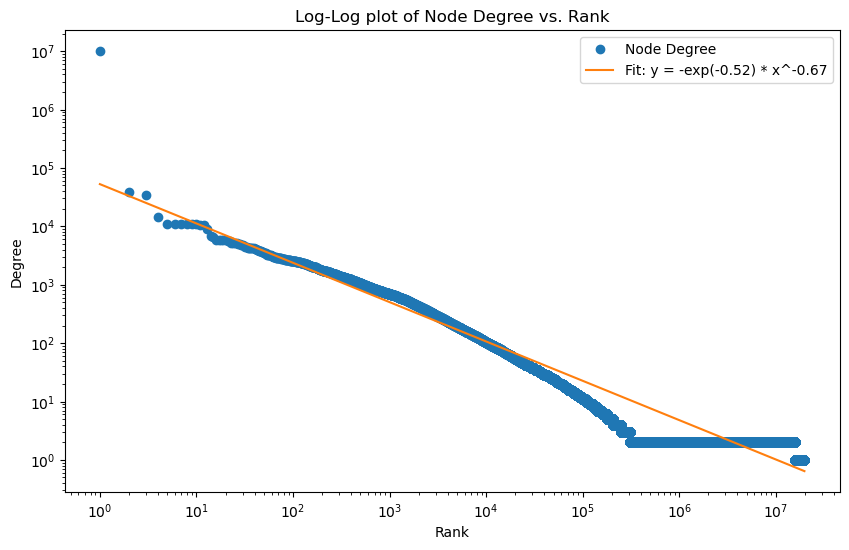

In [21]:
from scipy.optimize import curve_fit

# Log-transform the ranks and degrees
log_ranks = np.log(ranks)
log_degrees = np.log(sorted_degrees)

def power_law(x, a, b):
    return a * np.power(x, b)

# Excluding the first and last data point - outlier
params, covariance = curve_fit(power_law, ranks[1:-1], sorted_degrees[1:-1])  

fitted_line = power_law(ranks, *params)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_degrees, 'o', label='Node Degree')

plt.loglog(ranks, fitted_line, label=f'Fit: y = -exp(-0.52) * x^{params[1]:.2f}')

plt.text(0.8, 0.2, f'',horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel('Rank')
plt.ylabel('Degree')
plt.title('Log-Log plot of Node Degree vs. Rank')
plt.legend()
plt.show()

In [23]:
# Log-transform the fitted line and the degrees
log_fitted_line = np.log(fitted_line[1:-1])
log_sorted_degrees = np.log(sorted_degrees[1:-1])

# Calculate the correlation coefficient
correlation_matrix = np.corrcoef(log_fitted_line, log_sorted_degrees)
correlation_coefficient = correlation_matrix[0, 1]

print('Correlation coefficient:', correlation_coefficient)

Correlation coefficient: 0.9615551951255395


In [16]:
# Figure 4.3

In [17]:
degree_count = pd.Series(sorted_degrees).value_counts().sort_index(ascending=False)
ccdf = degree_count.cumsum() / degree_count.sum()

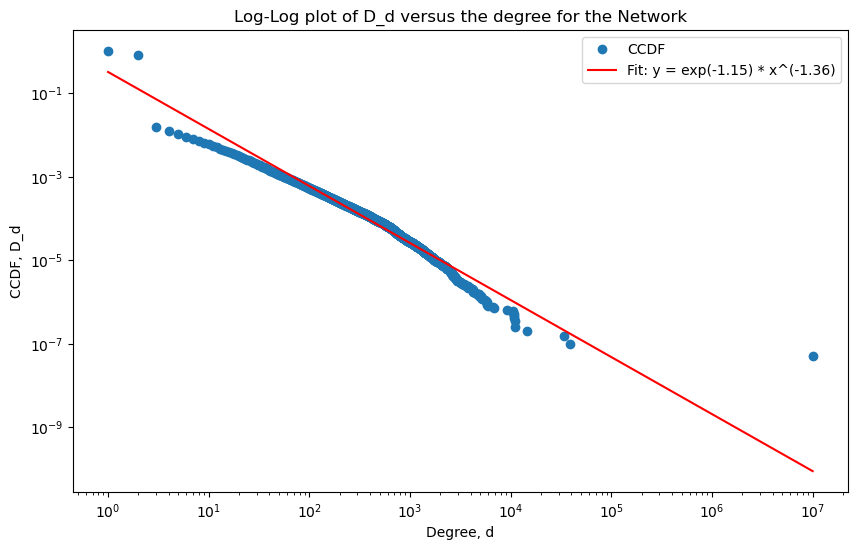

In [29]:
# Plotting the CCDF on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(ccdf.index, ccdf, marker='o', linestyle='None', label='CCDF')

# Fitting a line to the CCDF
log_degrees = np.log(ccdf.index)
log_ccdf = np.log(ccdf)

# Remove Outliers
valid_indices = ~(np.isinf(log_degrees) | np.isinf(log_ccdf))
log_degrees = log_degrees[valid_indices]
log_ccdf = log_ccdf[valid_indices]

slope, intercept = np.polyfit(log_degrees, log_ccdf, 1)
plt.plot(ccdf.index, np.exp(intercept) * (ccdf.index ** slope), color='red', label=f'Fit: y = exp({intercept:.2f}) * x^({slope:.2f})')

# Annotations for the equation
plt.text(0.8, 0.2, f'', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Labels, title, and legend
plt.xlabel('Degree, d')
plt.ylabel('CCDF, D_d')
plt.title('Log-Log plot of D_d versus the degree for the Network')
plt.legend()
plt.show()

In [28]:
slope, intercept = np.polyfit(log_degrees, log_ccdf, 1)
fitted_log_ccdf = slope * log_degrees + intercept

correlation_matrix = np.corrcoef(log_ccdf, fitted_log_ccdf)
correlation_coefficient = correlation_matrix[0, 1]

print('Correlation coefficient:', correlation_coefficient)

Correlation coefficient: 0.9824325933861654
